# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">0. Preambule</h1></span>

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">0.1 Disclaimer</h1></span>

<div class="alert alert-block alert-info">
    <font color = "red"></font> The following work don't use all the batches available, Kaggle's machines doesn't have enough RAM and VRAM to handle all the data. I'm aware that using so manay lines of code in a single notebook is a bad practice but i do it just for convenience. 
</div>

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">0.2 Installing Libraries</h1></span>

In [1]:
!pip install scmer
!pip install scanpy
!pip install spektral

     |████████████████████████████████| 2.0 MB 4.4 MB/s 
     |████████████████████████████████| 91 kB 9.1 MB/s 
     |████████████████████████████████| 103 kB 66.1 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=979a3c2da079b0ef72670f64e967f45170a1715ef68d6eb10c042ad0d4b360a8
  Stored in directory: /root/.cache/pip/wheels/68/ca/56/344d532fe53e855ccd6549795d370588ab8123907eecf4cf30
Successfully built sinfo
     |████████████████████████████████| 123 kB 4.9 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages th

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">0.3 Loading Libraries</h1></span>

In [2]:
### General Libraries ###
import gc
import os
import scipy
import random
import warnings
import numpy as np
import pandas as pd
from scipy import sparse as sp

### Data Visualization ###
from colorama import Fore
import matplotlib.pyplot as plt

### Single-Cell ###
import scanpy as sc
import anndata as ad
from scmer import UmapL1 # Feature selection
from anndata import AnnData

### Scikit-Learn ###
from sklearn.cluster import SpectralClustering

### Network's tools ###
import networkx as nx
import community as community_louvain

### RAPIDS Ecosystem ###
# Alternative for Numpy
import cupy
# Machine Learning
from cuml.manifold import TSNE
from cuml.decomposition import PCA
from cuml.neighbors.nearest_neighbors import kneighbors_graph

### Tensorflow Ecosystem ###
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MSE, KLD
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras import activations, constraints, initializers, regularizers
# Spektral for Graph Neural Networks
from spektral.layers import GATConv, GCSConv, TAGConv 

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">0.4 Configuration</h1></span>

In [3]:
seed = 42
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)    
    
set_seed(seed)

In [4]:
plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = [8, 6]
plt.style.use("fivethirtyeight")
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [5]:
### Make prettier the prints ###
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
m_ = Fore.MAGENTA
r_ = Fore.RED
y_ = Fore.YELLOW

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">1. Modeling</h1></span>


## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">1.1 Layers</h1></span>

In [6]:
class ClusteringLayer(Layer):
  def __init__(self, weights = None, alpha = 1.0, **kwargs):
    if "input_shape" not in kwargs and "input_dim" in kwargs:
      kwargs["input_shape"] = (kwargs.pop("input_dim"),)
    super(ClusteringLayer, self).__init__(**kwargs)
    self.alpha = alpha
    self.initial_weights = weights
    self.input_spec = InputSpec(ndim = 2)

  def build(self, input_shape):
    assert len(input_shape) == 2
    input_dim = input_shape[1]
    self.input_spec = InputSpec(dtype = K.floatx(), shape = (None, input_dim))
    self.clusters = self.add_weight(shape = None, initializer = "glorot_uniform",
                                    name = "clusters")
    if self.initial_weights is not None:
      self.set_weights(self.initial_weights)
      del self.initial_weights
    self.built = True

  def call(self, inputs, **kwargs):
    q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis = 1) - self.clusters),
                            axis = 2) / self.alpha))
    q **= (self.alpha + 1.0) / 2.0
    q = K.transpose(K.transpose(q) / K.sum(q, axis = 1))
    return q
  
  def compute_output_shape(self, input_shape):
    assert input_shape and len(input_shape) == 2
    return input_shape[0], self.n_clusters

  def get_config(self):
    config = {"n_clusters": self.n_clusters}
    base_config = super(ClusteringLayer, self).get_config()
    return dict(list(base_config.items()))

In [7]:
class Bilinear(Layer):
  def __init__(self,
               dropout = 0,
               use_bias = False,
               activation = None,
               kernel_initializer = "glorot_uniform",
               bias_initializer = "zeros",
               kernel_regularizer = None,
               bias_regularizer = None,
               activity_regularizer = None,
               kernel_constraint = None,
               bias_constraint = None,
               **kwargs):
    super().__init__(**kwargs)
    self.use_bias = use_bias
    self.dropout = dropout

    self.activation = activations.get(activation)
    self.kernel_initializer = initializers.get(kernel_initializer)
    self.bias_initializer = initializers.get(bias_initializer)
    self.kernel_regularizer = regularizers.get(kernel_regularizer)
    self.bias_regularizer = regularizers.get(bias_regularizer)
    self.activity_regularizer = regularizers.get(activity_regularizer)
    self.kernel_constraint = constraints.get(kernel_constraint)
    self.bias_constraint = constraints.get(bias_constraint)

  def build(self, input_shapes):
    self.kernel = self.add_weight(
        shape = (input_shapes[-1], input_shapes[-1]),
        initializer = self.kernel_initializer,
        name = "kernel",
        regularizer = self.kernel_regularizer,
        constraint = self.kernel_constraint
        )
    if self.use_bias:
      self.bias = self.add_weight(
          shape = (self.units,),
          initializer = self.bias_initializer,
          name = "bias",
          regularizer = self.bias_regularizer,
          constraint = self.bias_constraint
      )
    
    else:
      self.bias = None
    self.built = True
    super().build(input_shapes)
  
  def call(self, inputs, **kwargs):
    x = inputs
    x = tf.nn.dropout(x, self.dropout)
    h1 = tf.matmul(x, self.kernel)
    output = tf.matmul(h1, tf.transpose(x))

    if self.use_bias:
      output += self.bias
    
    return self.activation(output)

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">1.2 Clustering</h1></span>

In [8]:
# Compute cluster centroids, which is the mean of all points in one cluster
def computeCentroids(data, labels):
    n_clusters = len(np.unique(labels))
    return np.array([data[labels == i].mean(0) for i in range(n_clusters)])

In [9]:
class louvain:
    def __init__(self, level):
        self.level = level
        return 
  
    def updateLabels(self, level):
        # Louvain algorithm labels community at different level (with dendrogram).
        # Here we want the community labels at a given level.
        level = int((len(self.dendrogram) - 1) * level)
        partition = community_louvain.partition_at_level(self.dendrogram, level)
        # Convert dictionary to numpy array
        self.labels = np.array(list(partition.values()))
        return 

    def update(self, inputs, adj_mat = None):
        """
        Return the parittion of the nodes at the given level

        A dendrogram is a tree and each level is a partition of the graph nodes.
        Lecel 0 is the first parittion, which contains the smallest communities,
        and the best is len(dendrogram) - 1
        Higher the level is, bigger the communities are
        """
        self.graph = nx.from_numpy_matrix(adj_mat)
        self.dendrogram = community_louvain.generate_dendrogram(self.graph)
        self.updateLabels(self.level)
        self.centroids = computeCentroids(inputs, self.labels)
        return 

In [10]:
def clustering(h, n_cluster, k = 15, f = "louvain"):
    adj, adj_n = get_adj(h, k = k, pca = False)
    if f == "louvain":
        cl_model = louvain(level = 0.5)
        cl_model.update(h, adj_mat = adj)
        labels = cl_model.labels
    elif f == "spectral":
        labels = SpectralClustering(n_clusters=n_cluster, affinity="precomputed", assign_labels="discretize",
                                    random_state=0).fit_predict(adj)
    elif f == "kmeans":
        labels = KMeans(n_clusters = n_cluster, random_state = 0).fit(h).labels_
    return labels

In [11]:
def get_centers_louvain(Y, adj):
    cl_model = louvain(level=0.5)
    cl_model.update(Y, adj_mat=model.adj)
    labels = cl_model.labels
    centers = computeCentroids(Y, labels)
    return centers, labels

In [12]:
def get_centers_spectral(Y, adj):
    l = SpectralClustering(
        n_clusters = 10, 
        affinity = "precomputed", 
        assign_labels = "discretize", 
        random_state = 0).fit_predict(adj)
    centers = computeCentroids(Y, l)
    return centers, l

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">1.3 Losses</h1></span>

In [13]:
def cdisttf(data_1, data_2):
    prod = tf.math.reduce_sum(
      (tf.expand_dims(data_1, 1) - tf.expand_dims(data_2, 0)) ** 2, 2
    )
    return (prod + 1e-10) ** (1 / 2)

In [14]:
def dist_loss(data, min_dist, max_dist = 20):
    pairwise_dist = cdisttf(data, data)
    dist = pairwise_dist - min_dist
    bigdist = max_dist - pairwise_dist
    loss = tf.math.exp(-dist) + tf.math.exp(-bigdist)
    return loss

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">1.4 Utils</h1></span>

In [15]:
def embedding_scatter(Y, class_idxs, legend = True, ran = True, seed = seed):
    if ran:
        np.random.seed(seed)
    Y = np.array(Y)
    fig, ax = plt.subplots(figsize = (6, 4), dpi = 300)
    classes = list(np.unique(class_idxs))
    markers = "osD" * len(classes)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(classes)))

    if ran:
        np.random.shuffle(colors)

    for i, cls in enumerate(classes):
        mark = markers[i]
        ax.plot(
          Y[class_idxs == cls, 0], Y[class_idxs == cls, 1], marker = mark,
          linestyle = '', ms = 4, label = str(cls), alpha = 1,
          color = colors[i], markeredgecolor = "black", markeredgewidth = 0.15
        )
    if legend:
        ax.legend(prop = {"size": 4}, loc = 1, ncol = 2,
                  fontsize = "medium"
              )
    #plt.title("Cell Populations on scGAE Embedding")
    plt.xticks([])
    plt.yticks([])

    return ax

In [16]:
def dotsne(X, dim = 2, ran = 23):
    tsne = TSNE(n_components = dim, random_state = ran)
    Y_tsne = tsne.fit_transform(X)
    return Y_tsne

In [17]:
def dopca(X, dim = 10):
    pcaten = PCA(n_components= dim)
    X_10 = pcaten.fit_transform(X)
    return X_10

In [18]:
def norm_hvg(adata, filter_min = True, norm_cell = True, log = True, top_genes = 2500, 
              scale = True):
    """
    This function gather all methods to get Highly Variable Genes with Scanpy
    """
    if filter_min:
        sc.pp.filter_genes(adata, min_counts = 100)
        sc.pp.filter_cells(adata, min_counts = 3)

    if norm_cell:
        sc.pp.normalize_total(adata, target_sum = 1e4)
    
    if log:
        sc.pp.log1p(adata)

    if top_genes:
        sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5,
                                n_top_genes = top_genes)
    
    adata.var.highly_variable.sum()
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    
    if scale:
        sc.pp.scale(adata, max_value = 10)
  
    return adata

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">1.5 Adjacency</h1></span>

In [19]:
def degree_power(A, k):
    degrees = cupy.power(cupy.array(A.sum(1)), k).flatten()
    degrees[cupy.isinf(degrees)] = 0.
    if sp.issparse(A):
        D = sp.diags(degrees)
    else:
        D = np.diag(degrees)
    return D

In [20]:
def norm_adj(A):
    normalized_D = degree_power(A, -0.5)
    output = normalized_D.dot(A).dot(normalized_D)
    return output

In [21]:
def get_adj(count, k = 35, pca = 50, mode = "connectivity"):
    if pca:
        countp = dopca(count, dim = pca)
    else:
        countp = count
    
    A = kneighbors_graph(countp, k, mode = mode, metric = "euclidean", include_self = True)
    adj = A.toarray()
    adj_n = norm_adj(adj)
    return adj, adj_n

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">1.6 single-cell Graph AutoEncoder (scGAE)</h1></span>

In [22]:
class SCGAE(tf.keras.Model):
  
  def __init__(self, X, adj, adj_n, hidden_dim = 128, latent_dim = 10,
               dec_dim = None, adj_dim = 32, decA = "DBL", layer_enc = "GAT"):
    super(SCGAE, self).__init__()
    if dec_dim is None:
      dec_dim = [64, 256, 512]
    self.latent_dim = latent_dim
    self.X = X
    self.adj = np.float32(adj)
    self.adj_n = np.float32(adj_n)
    self.n_sample = X.shape[0]
    self.in_dim = X.shape[1]
    self.sparse = False

    initializer = GlorotUniform(seed = 7)

    ### Encoder ###
    X_input = Input(shape = self.in_dim)
    h = Dropout(0.2)(X_input)
    
    if layer_enc == "GAT":
      A_in = Input(shape = self.n_sample)
      h = GATConv(channels = hidden_dim, attn_heads = 1,
                  kernel_initializer = initializer, activation = "relu")([h, A_in])
      z_mean = GATConv(channels = latent_dim, kernel_initializer = initializer,
                       attn_heads = 1)([h, A_in])
    
    elif layer_enc == "GCN":
      A_in = Input(shape = self.n_sample)
      h = GCSConv(channels = hidden_dim, kernel_initializer = initializer,
                  activation = "relu")([h, A_in])
      z_mean = GCSConv(channels = latent_dim, kernel_initializer = initializer)([h, A_in])
    
    elif layer_enc == "TAG":
      self.sparse = True
      A_in = Input(shape = self.n_sample, sparse = True)
      h = TAGConv(channels = hidden_dim, kernel_initializer = initializer,
                  activation = "relu")([h, A_in])
      z_mean = TAGConv(channels = latent_dim, kernel_initializer = initializer)([h, A_in])
    
    self.encoder = Model(inputs = [X_input, A_in], outputs = z_mean, name = "encoder")
    clustering_layer = ClusteringLayer(name = "clustering")(z_mean)
    self.cluster_model = Model(inputs = [X_input, A_in], outputs = clustering_layer,
                               name = "cluster_encoder")
    
    ### Adjacency matrix encoder ###
    if decA == "DBL":
      dec_in = Input(shape = latent_dim)
      h = Dense(units = adj_dim, activation = None)(dec_in)
      h = Bilinear()(h)
      dec_out = Lambda(lambda z: tf.nn.sigmoid(z))(h)
      self.decoderA = Model(inputs = dec_in, outputs = dec_out, name = "decoder1")
    
    elif decA == "BL":
      dec_in = Input(shape = latent_dim)
      h = Bilinear()(dec_in)
      dec_out = Lambda(lambda z: tf.nn.sigmoid(z))(h)
      self.decoderA = Model(inputs = dec_in, outputs = dec_out, name = "decoder1")
    
    elif decA == "IP":
      dec_in = Input(shape = latent_dim)
      dec_out = Lambda(lambda z: tf.nn.sigmoid(tf.matmul(z, tf.transpose(z))))(dec_in)
      self.decoderA = Model(inputs = dec_in, outputs = dec_out, name = "decoder1")
    
    else:
      self.decoderA = None
    
    # Expression matrix decoder
    decx_in = Input(shape = latent_dim)
    h = Dense(units = dec_dim[0], activation = "relu")(decx_in)
    h = Dense(units = dec_dim[1], activation = "relu")(h)
    h = Dense(units = dec_dim[2], activation = "relu")(h)
    decx_out = Dense(units = self.in_dim)(h)
    self.decoderX = Model(inputs = decx_in, outputs = decx_out, name = "decoderX")
  
  def pre_train(self, epochs = 80, info_step = 10, lr = 2e-3, W_a = 0.3, W_x = 1,
                W_d = 0, min_dist = 0.5, max_dist = 20):
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    if self.sparse == True:
      self.adj_n = tfp.math.dense_to_sparse(self.adj_n)
    
    ### Training ###
    for epoch in range(1, epochs + 1):
      with tf.GradientTape(persistent = True) as tape:
        z = self.encoder([self.X, self.adj_n])
        X_out = self.decoderX(z)
        A_out = self.decoderA(z)
        if W_d:
          Dist_loss = tf.reduce_mean(dist_loss(z, min_dist, max_dist = max_dist))
        A_rec_loss = tf.reduce_mean(MSE(self.adj, A_out))
        X_rec_loss = tf.reduce_mean(MSE(self.X, X_out))
        loss = W_a * A_rec_loss + W_x * X_rec_loss
        if W_d:
          loss += W_d * Dist_loss
      
      vars = self.trainable_weights
      grads = tape.gradient(loss, vars)
      optimizer.apply_gradients(zip(grads, vars))

      if epoch % info_step == 0:
          if W_d:
              print(g_,"Epoch", epoch)
              print(b_,"X_rec_loss:", r_,X_rec_loss.numpy(), b_,"  A_rec_loss:",r_, A_rec_loss.numpy(),
                b_,"  Dist_loss:", r_,Dist_loss.numpy())
          else:
              print(g_,"Epoch", epoch)
              print(b_,"X_rec_loss:",r_, X_rec_loss.numpy(), b_,"  A_rec_loss:", r_,A_rec_loss.numpy())
    print(y_,"Pre-train Finished!")
  
  def alt_train(self, epochs = 100, lr = 5e-4, W_a = 0.3, W_x = 1, W_c = 1.5,
                info_step = 8, n_update = 8, centers = None):
    self.cluster_model.get_layer(name = "clustering").clusters = centers

    ### Training ### 
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
    for epoch in range(0, epochs):
      if epoch % n_update == 0:
        q = self.cluster_model([self.X, self.adj_n])
        p = self.target_distribution(q)
      
      with tf.GradientTape(persistent = True) as tape:
        z = self.encoder([self.X, self.adj_n])
        q_out = self.cluster_model([self.X, self.adj_n])
        X_out = self.decoderX(z)
        A_out = self.decoderA(z)
        A_rec_loss = tf.reduce_mean(MSE(self.adj, A_out))
        X_rec_loss = tf.reduce_mean(MSE(self.X, X_out))
        cluster_loss = tf.reduce_mean(KLD(q_out, p))
        tot_loss = W_a * A_rec_loss + W_x * X_rec_loss, W_c * cluster_loss

      vars = self.trainable_weights
      grads = tape.gradient(tot_loss, vars)
      optimizer.apply_gradients(zip(grads, vars))

      if epoch % info_step == 0:
        print(g_, "Epoch", epoch)
        print(b_,"X_rec_loss: ", r_, X_rec_loss.numpy(), b_, " A_rec_loss", r_,
              A_rec_loss.numpy(), b_, " cluster loss: ", r_, cluster_loss.numpy())
  
  def target_distribution(self, q):
    q = q.numpy()
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T
  
  def embedding(self, count, adj_n):
    if self.sparse:
      adj_n = tfp.math.dense_to_sparse(adj_n)
    return np.array(self.encoder([count, adj_n]))
  
  def rec_A(self, count, adj_n):
    h = self.encoder([count, adj_n])
    rec_A = self.decoderA(h)
    return np.array(rec_A)

  def get_label(self, count, adj_n):
    if self.sparse:
      adj_n = tfp.math.dense_to_sparse(adj_n)
    clusters = self.cluster_model([count, adj_n]).numpy()
    labels = np.array(clusters.argmax(1))
    return labels.reshape(-1, )

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">2. The Data</h1></span>

In [23]:
adata_gex = ad.read_h5ad("../input/singlecell-multiomics/multiome_gex_processed_training.h5ad")
print(f"{b_}The GEX data has {r_}{adata_gex.n_obs}{b_} observations and {r_}{adata_gex.n_vars}{b_} features.")

The GEX data has 22463 observations and 13431 features.


In [24]:
adata_gex.var

,gene_ids,feature_types,genome
AL627309.5,ENSG00000241860,GEX,GRCh38
LINC01409,ENSG00000237491,GEX,GRCh38
LINC01128,ENSG00000228794,GEX,GRCh38
NOC2L,ENSG00000188976,GEX,GRCh38
KLHL17,ENSG00000187961,GEX,GRCh38
...,...,...,...
MT-ND5,ENSG00000198786,GEX,GRCh38
MT-ND6,ENSG00000198695,GEX,GRCh38
MT-CYB,ENSG00000198727,GEX,GRCh38
AL592183.1,ENSG00000273748,GEX,GRCh38


In [25]:
adata_gex.obs

,n_genes_by_counts,pct_counts_mt,n_counts,n_genes,size_factors,phase,cell_type,pseudotime_order_GEX,batch
TAGTTGTCACCCTCAC-1-s1d1,1022,1.061008,1508.0,1022,0.453484,S,Naive CD20+ B,NaN,s1d1
CTATGGCCATAACGGG-1-s1d1,1081,0.604230,1655.0,1081,0.455631,G2M,CD14+ Mono,NaN,s1d1
CCGCACACAGGTTAAA-1-s1d1,3304,0.650069,7230.0,3304,2.435348,G2M,CD8+ T,NaN,s1d1
TCATTTGGTAATGGAA-1-s1d1,793,0.812274,1108.0,793,0.347226,G2M,CD8+ T,NaN,s1d1
ACCACATAGGTGTCCA-1-s1d1,1219,1.674770,1851.0,1219,0.534205,G2M,CD16+ Mono,NaN,s1d1
...,...,...,...,...,...,...,...,...,...
TAGTAAGCAACTAGGG-8-s3d6,1313,0.000000,1937.0,1313,0.522115,S,HSC,0.098024,s3d6
TGGTCCTTCGGCTAGC-8-s3d6,2846,0.015901,6289.0,2846,1.737451,G2M,CD4+ T activated,NaN,s3d6
CGCTTGCGTTGTTGGA-8-s3d6,983,0.000000,1390.0,983,0.291723,G2M,pDC,NaN,s3d6
ACCCTCCCAGCCAGTT-8-s3d6,1351,0.000000,2190.0,1351,0.585303,G2M,CD8+ T,NaN,s3d6


In [26]:
adata_gex.X

<22463x13431 sparse matrix of type '<class 'numpy.float64'>'
	with 29780766 stored elements in Compressed Sparse Column format>

In [27]:
adata_gex.obs["cell_type"].nunique()

21

In [28]:
adata_gex.obs["cell_type"].size == adata_gex.n_obs

True

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">2.1 Splitting the Data</h1></span>

In [29]:
train = adata_gex[adata_gex.obs["batch"].isin(["s1d2", "s3d6"])]
print(f"{b_}train.X.shape: {r_}{train.X.shape}")

train.X.shape: (7580, 13431)


## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">2.2 Highly Variable Genes</h1></span>

In [30]:
train = norm_hvg(train)

Trying to set attribute `.var` of view, copying.
/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [31]:
print(f"{b_}train.X.shape: {r_}{train.X.shape}")

train.X.shape: (7580, 2500)


## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">2.3 Visualizing the Data Using UMAP</h1></span>



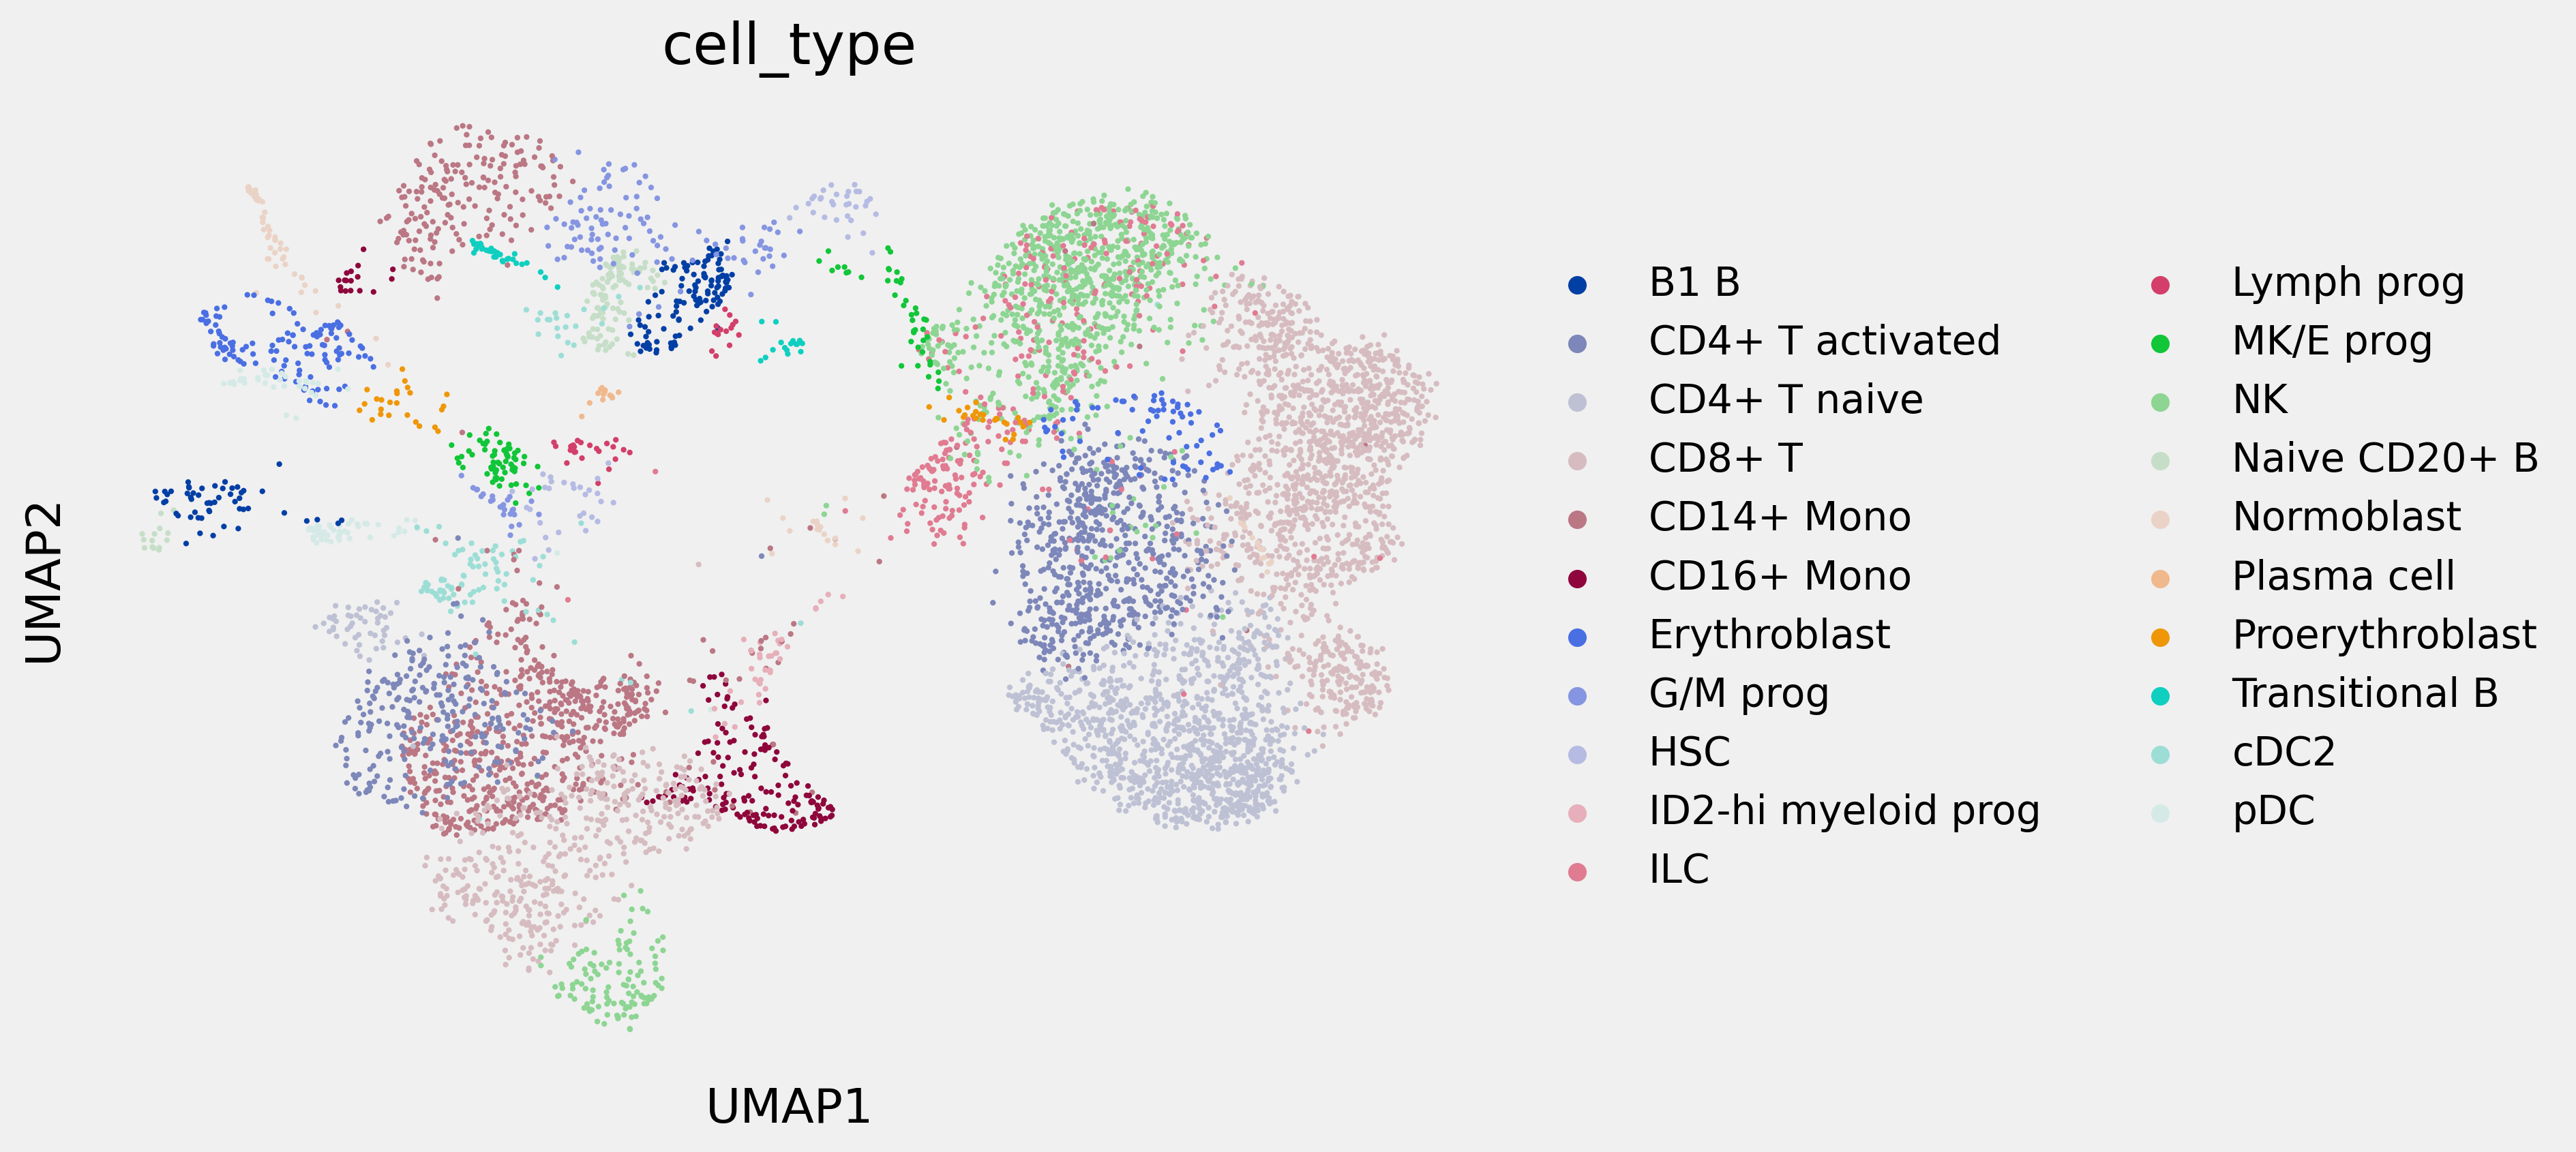

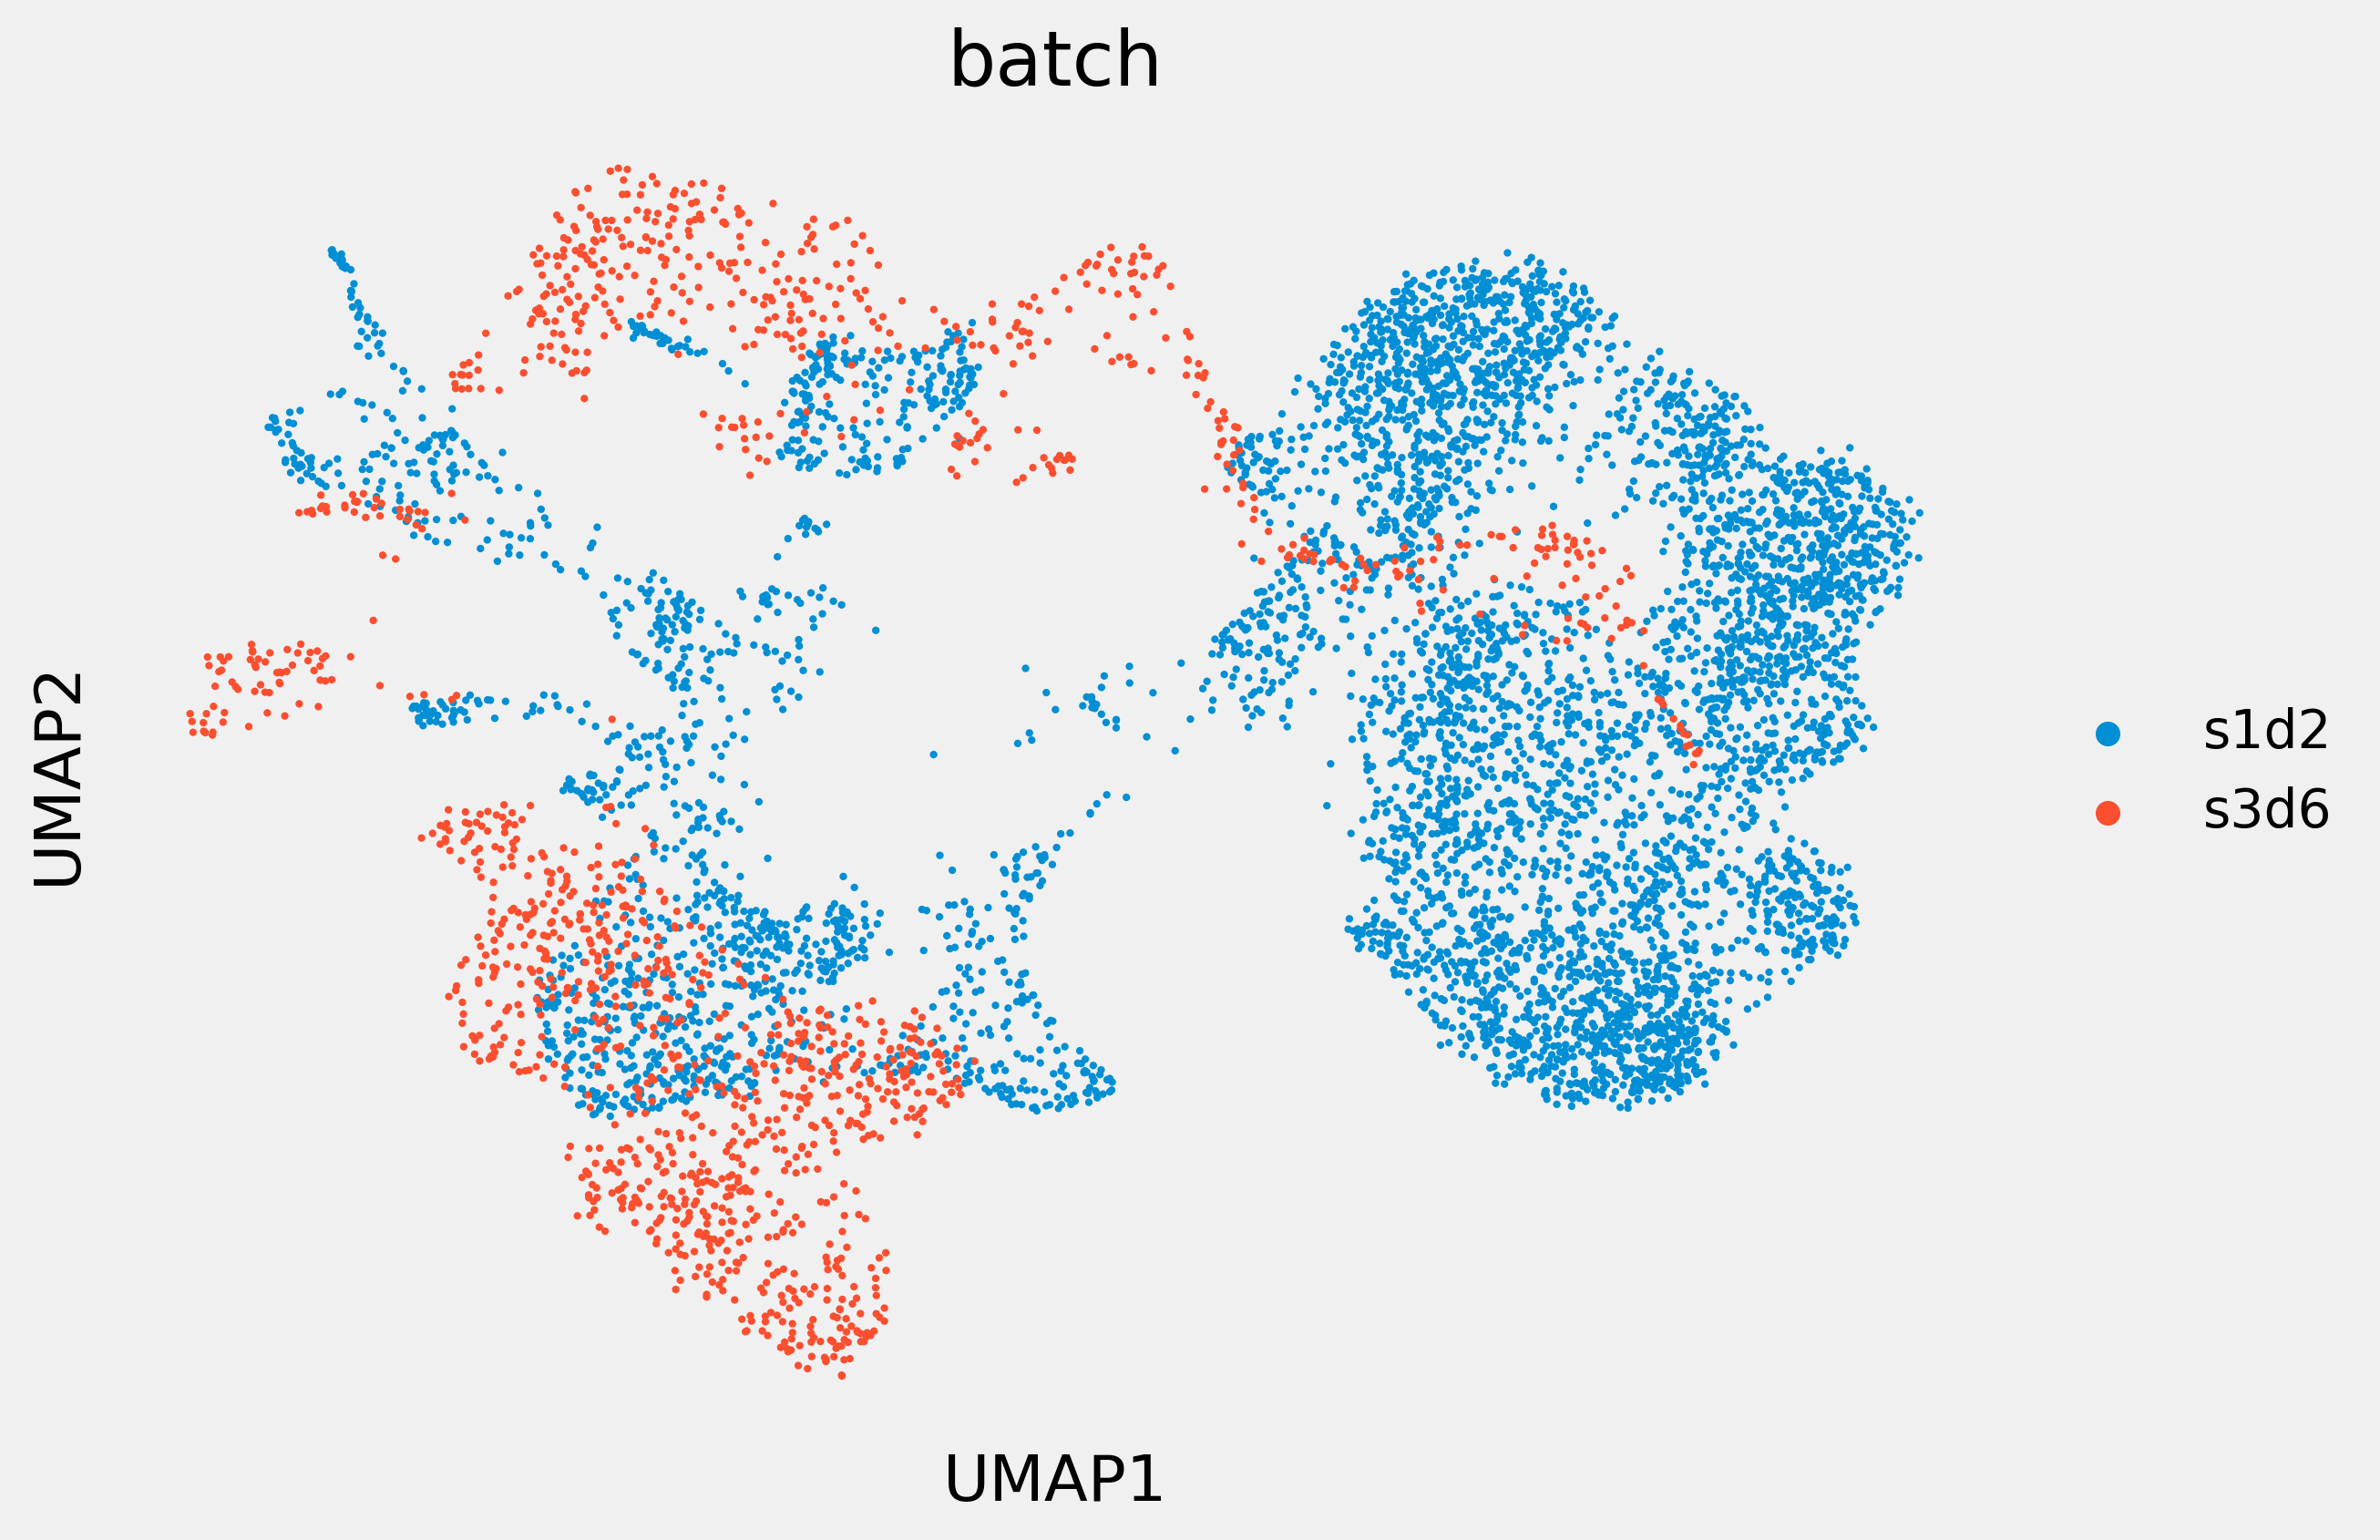

In [32]:
sc.pl.umap(train, color = "cell_type")
sc.pl.umap(train, color = "batch")

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">3. Feature Selection with SCMER</h1></span>

In [33]:
model = UmapL1(
    w = 1., 
    lasso = 3.3e-4,
    ridge = 0.,
    n_pcs = 25,
    perplexity = 100.,
    use_beta_in_Q = True,
    n_threads = os.cpu_count(),
    max_outer_iter = 3,
    use_gpu = True # It's faster with GPU
)

In [34]:
%%time
model.fit(train.X)

Calculating distance matrix and scaling factors...
Computing pairwise distances...
Using 2 threads...
Mean value of sigma: 0.820287
Done. Elapsed time: 438.93 seconds. Total: 438.93 seconds.
Creating model without batches...
Optimizing using OWLQN (because lasso is nonzero)...
0 loss (before this step): 5.409222602844238 Nonzero (after): 190 Elapsed time: 20.56 seconds. Total: 459.49 seconds.
1 loss (before this step): 3.859731912612915 Nonzero (after): 187 Elapsed time: 7.50 seconds. Total: 466.99 seconds.
2 loss (before this step): 3.8576340675354004 Nonzero (after): 185 Elapsed time: 9.29 seconds. Total: 476.27 seconds.
Final loss: 3.755699396133423 Nonzero: 185 Elapsed time: 0.08 seconds. Total: 476.36 seconds.
CPU times: user 34.4 s, sys: 3.52 s, total: 38 s
Wall time: 7min 56s


## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">3.1 Adata with Just Selected Genes</h1></span>

In [35]:
selected_genes = train.var_names[model.get_mask(100)]
new_adata = train[:, selected_genes]

print(g_, "ALL SELECTED GENES: \n")
print(b_, *selected_genes)
print(y_, "=" * 60)
print(f"{m_}Number of selected genes: {r_}{len(selected_genes)}")

 ALL SELECTED GENES: 

 PADI4 CD52 CSF3R TGFBR3 CDC14A S100A4 SPTA1 FCER1G CD247 RALGPS2 AL136456.1 ID2 SLC8A1 GNLY AFF3 ZEB2 SLC4A10 IKZF2 FGFBP2 TXK BANK1 LEF1 INPP4B IL7R GZMK GZMA VCAN CAMK4 CD74 EBF1 LTB HLA-DRA HLA-DRB1 HLA-DPB1 RUNX2 EEF1A1 BACH2 THEMIS TNFAIP3 PHACTR2 AOAH AUTS2 NAMPT MYOM2 ANK1 LYN TOX PAG1 NCALD MTSS1 CEMIP2 ANXA1 PLXDC2 ANK3 PRF1 LRMDA TCF7L2 HBB PDE3B MS4A1 NEAT1 MALAT1 ZBTB16 CD3D CD69 KLRF1 KLRD1 RPL41 IRAK3 FRY TRAC GZMH GZMB SLC25A21 PRKCH SYNE2 FOS IGHM FMN1 B2M DMXL2 MCTP2 RPS2 IL32 CCL5 CCL4 SLC4A1 PRKCA PITPNC1 CD7 LINC01478 BCL2 TYROBP NKG7 PLCB1 SAMSN1 ERG TYMP SAT1 XACT
Number of selected genes: 100


In [36]:
gc.collect()

42

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">3.2 Preparing Inputs</h1></span>

In [37]:
count = new_adata.X
count.shape

(7580, 100)

In [38]:
idents = new_adata.obs["cell_type"]
idents = np.array(idents)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">4. Training scGAE</h1></span>

In [39]:
# Compute adjacency matrix and normalized adjacency matrix
adj, adj_n = get_adj(count, k = 160)

In [40]:
adj, adj_n = adj.get(), adj_n.get()

In [41]:
gc.collect()

105

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">4.1 Pre-Training</h1></span>

In [42]:
### Build Model ###
model = SCGAE(
    count, 
    adj = adj, 
    adj_n = adj_n, 
    hidden_dim = 120,
    latent_dim = 10,
    decA = "DBL",
    layer_enc = "GAT"
)

2021-11-18 00:34:40.982678: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 00:34:40.983949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 00:34:40.984509: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-18 00:34:40.985218: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [43]:
### Pre-training ###
model.pre_train(
    epochs = 200,
    W_a = 0.4,
    W_x = 1
)

 Epoch 10
 X_rec_loss:  0.7906501    A_rec_loss:  0.03289242
 Epoch 20
 X_rec_loss:  0.660778    A_rec_loss:  0.021077523
 Epoch 30
 X_rec_loss:  0.6048007    A_rec_loss:  0.02108326
 Epoch 40
 X_rec_loss:  0.5706475    A_rec_loss:  0.021095352
 Epoch 50
 X_rec_loss:  0.5375872    A_rec_loss:  0.021100216
 Epoch 60
 X_rec_loss:  0.51902413    A_rec_loss:  0.021104798
 Epoch 70
 X_rec_loss:  0.49755666    A_rec_loss:  0.021106247
 Epoch 80
 X_rec_loss:  0.481143    A_rec_loss:  0.02110702
 Epoch 90
 X_rec_loss:  0.46760046    A_rec_loss:  0.021107446
 Epoch 100
 X_rec_loss:  0.45685598    A_rec_loss:  0.021107491
 Epoch 110
 X_rec_loss:  0.44633785    A_rec_loss:  0.021107582
 Epoch 120
 X_rec_loss:  0.4388667    A_rec_loss:  0.021107664
 Epoch 130
 X_rec_loss:  0.432088    A_rec_loss:  0.021107595
 Epoch 140
 X_rec_loss:  0.42611784    A_rec_loss:  0.021107618
 Epoch 150
 X_rec_loss:  0.42129856    A_rec_loss:  0.021107709
 Epoch 160
 X_rec_loss:  0.41768938    A_rec_loss:  0.021107648

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">4.2 Visualization of this Results</h1></span>

<AxesSubplot:>

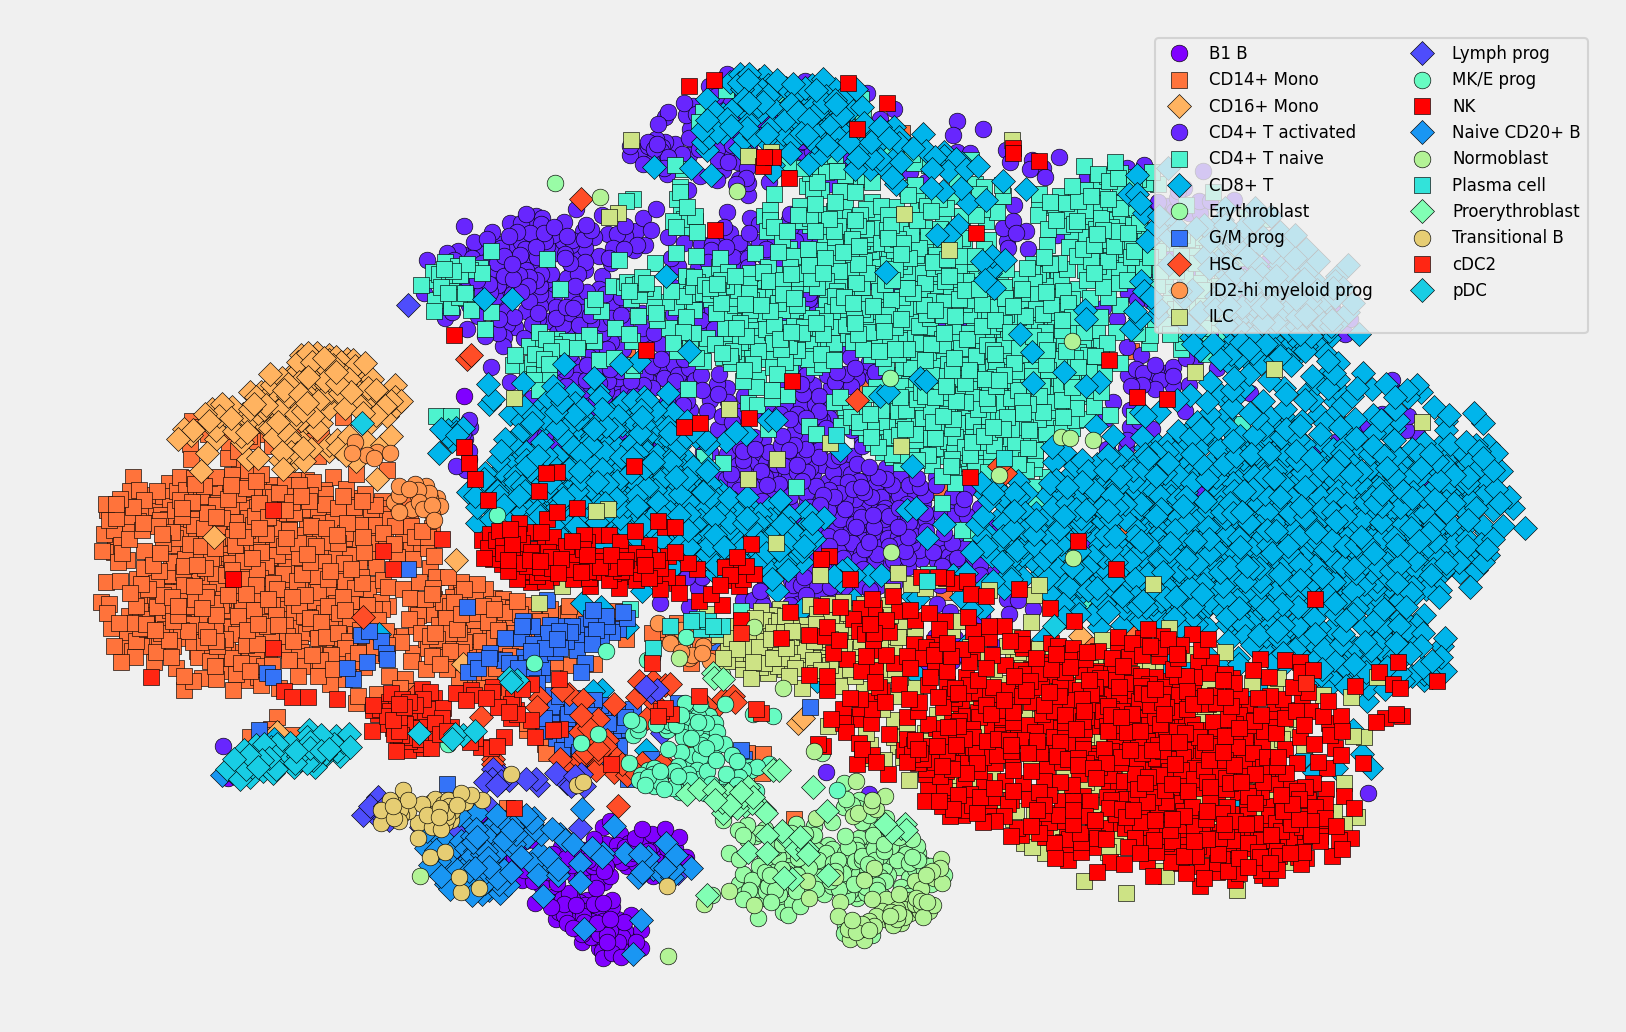

In [44]:
### Generate latent embedding and visualization ###
Y = model.embedding(count, adj_n)
Y2 = dotsne(Y)
embedding_scatter(Y2, idents)

In [45]:
# Spectral clustering 
centers, labels = get_centers_spectral(Y, adj)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(**kwargs)


## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">4.3 Train</h1></span>

In [46]:
### Clustering training ###
model.alt_train(centers =centers, W_a = 0.4, W_x = 1, W_c = 1.5, epochs = 40)

 Epoch 0
 X_rec_loss:   0.41145685   A_rec_loss  0.02110774   cluster loss:   0.20099144
 Epoch 8
 X_rec_loss:   0.4104462   A_rec_loss  0.021107886   cluster loss:   0.2201492
 Epoch 16
 X_rec_loss:   0.41069958   A_rec_loss  0.021108089   cluster loss:   0.23479071
 Epoch 24
 X_rec_loss:   0.41491762   A_rec_loss  0.021108145   cluster loss:   0.24818167
 Epoch 32
 X_rec_loss:   0.41942546   A_rec_loss  0.021108156   cluster loss:   0.25987375


## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">4.4 Final Embedding</h1></span>

<AxesSubplot:>

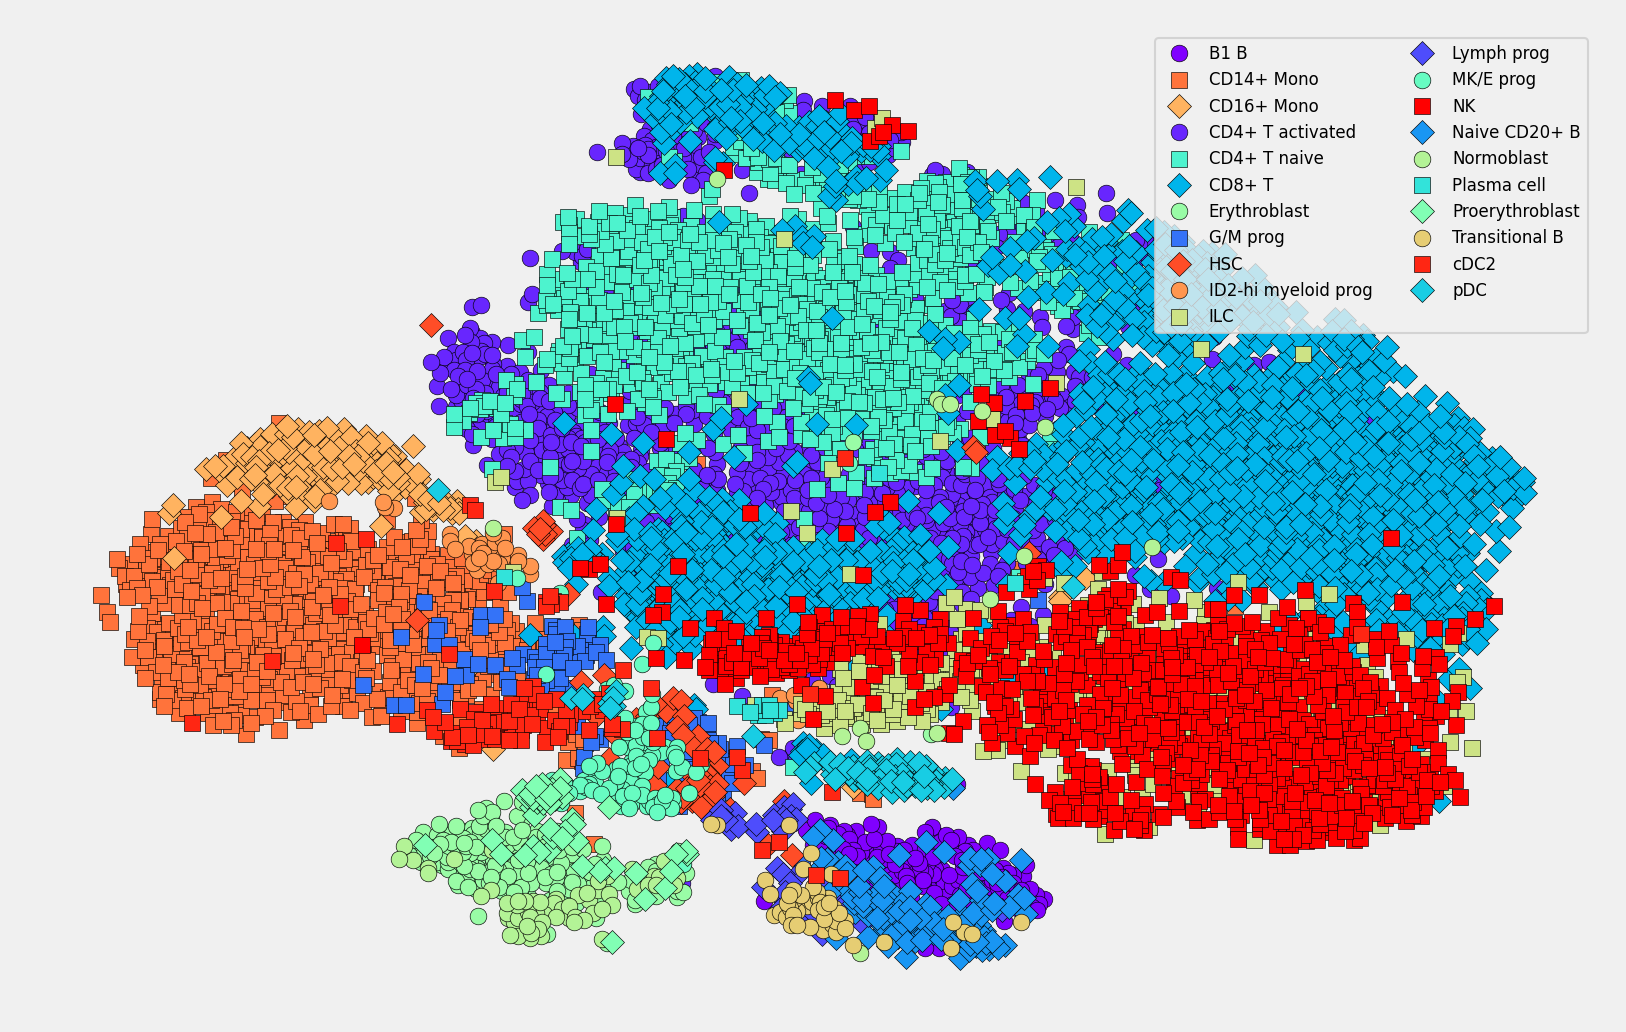

In [47]:
### Generate latent embedding and visualization after clustering-training
Ynew = model.embedding(count, adj_n)
Y2new = dotsne(Ynew, dim = 2)
embedding_scatter(Y2new, idents)


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">5. References</h1></span>

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">5.1 Papers</h1></span>

s2d1- Luo, Z., Xu, C., Zhang, Z. et al. A topology-preserving dimensionality reduction method for single-cell RNA-seq data using graph autoencoder. Sci Rep 11, 20028 (2021). https://doi.org/10.1038/s41598-021-99003-7
- Luecken, M. D., & Theis, F. J. (2019). Current best practices in single‐cell RNA‐seq analysis: a tutorial. Molecular systems biology, 15(6), e8746.
- Wolf, F. A., Angerer, P., & Theis, F. J. (2018). SCANPY: large-scale single-cell gene expression data analysis. Genome biology, 19(1), 1-5.
- Liang, S., Mohanty, V., Dou, J., Miao, Q., Huang, Y., Müftüoğlu, M., ... & Chen, K. (2021). Single-cell manifold-preserving feature selection for detecting rare cell populations. Nature Computational Science, 1(5), 374-384.

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">5.2 Repositories</h1></span>

- https://github.com/ZixiangLuo1161/scGAE

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">5.3 Documentation</h1></span>

- **[Spektral](https://graphneural.network/)**
- **[RAPIDS](https://rapids.ai/)**

## <span><h1 style = "font-family: garamond; font-size: 30px; font-style: normal; letter-spcaing: 1.5px; background-color: #90EE90; color :  #388E3C; border-radius: 100px 100px; text-align:center">5.3 My Related Works</h1></span>

- [scRNA-seq 🧬: Scanpy & SCMER for Feature Selection](https://www.kaggle.com/hiramcho/scrna-seq-scanpy-scmer-for-feature-selection#4.-References)